## Visual Question Answering

### Preparing for CLIP

In [1]:
! pip install ftfy regex tqdm --q --root-user-action=ignore
! pip install git+https://github.com/openai/CLIP.git --q --root-user-action=ignore
! pip install pytorch-lightning --q --root-user-action=ignore

## Importing libraries

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message="unable to load libtensorflow_io_plugins.so")
warnings.filterwarnings("ignore", category=UserWarning, message="file system plugins are not loaded")
warnings.filterwarnings("ignore", category=FutureWarning, message="`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4.")

In [3]:
import numpy as np
import skimage
import torch
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import clip
import gc
import nltk
import torch
import torch.nn as nn
import pytorch_lightning as pl
import inspect

from tabulate import tabulate
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from pkg_resources import packaging
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS
from sklearn.preprocessing import OneHotEncoder
from torch.nn import functional as F
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data.dataset import TensorDataset

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Helping Functions

In [14]:
def print_variable_shapes(*variable_names):
    # Create a list of lists for the table data
    table_data = []
    for variable_name in variable_names:
        try:
            variable = eval(variable_name)
            table_data.append([variable_name, variable.shape])
        except NameError:
            table_data.append([variable_name, "Variable not found"])

    # Print the table
    table_headers = ["Variable", "Shape"]
    print(tabulate(table_data, headers=table_headers, tablefmt="grid"))


## 1. Download the Dataset and Data analysis (20 Points)

### a,b) Reading data as panda dataframe
Using Kaggle you will be able to mount the data instantly without any hustle.

In [36]:
DATA_DIR = "/kaggle/input/vizwiz/"
PICKLE_DIR = "/kaggle/input/vizwiz-pickle/"
MODEL_DIR = "/kaggle/input/vizwiz-model/"

In [28]:
# Reading the dataset
df = pd.read_json(DATA_DIR + "Annotations/Annotations/train.json")
val_df = pd.read_json(DATA_DIR + "Annotations/Annotations/val.json")
sample_df = pd.read_json(DATA_DIR + "Annotations/Annotations/test.json")
df = df.rename(columns={'image': 'image_label'})
df.head()
# df[df['answer_type']=='number'].head()

image_label  \
0  VizWiz_train_00000000.jpg   
1  VizWiz_train_00000001.jpg   
2  VizWiz_train_00000002.jpg   
3  VizWiz_train_00000003.jpg   
4  VizWiz_train_00000004.jpg   

                                            question  \
0                   What's the name of this product?   
1        Can you tell me what is in this can please?   
2  Is this enchilada sauce or is this tomatoes?  ...   
3            What is the captcha on this screenshot?   
4                                 What is this item?   

                                             answers answer_type  answerable  
0  [{'answer_confidence': 'yes', 'answer': 'basil...       other           1  
1  [{'answer_confidence': 'yes', 'answer': 'soda'...       other           1  
2  [{'answer_confidence': 'yes', 'answer': 'these...       other           1  
3  [{'answer_confidence': 'yes', 'answer': 't36m'...       other           1  
4  [{'answer_confidence': 'yes', 'answer': 'solar...       other           1

### c) Take 0.05 of the training data as test data.
Don’t forget to set seed 42 and stratify to true and remember that the answer/answer confidence pairs correspond to the images and questions.

In [7]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.05, random_state=42, stratify=df['answer_type'])# Count the occurrences of each answer type

#### Get Most Common Answer

In [8]:
# Function to get the most common answer
def get_common_answer(answers):
    gathered_answers = {}
    temp = []
    # Get all the answers
    for answer in answers:
        temp.append(answer['answer'])
    # Count the occurrences of each answer
    count = Counter(temp)
    num = max(list(count.values()))
    # Get the most common answer
    repeated_answers = []
    for i,j in enumerate(list(count.values())):
        if num == j:
            repeated_answers.append(list(count.keys())[i])
            
    # If there is only one answer that is repeated
    if (len(repeated_answers) == 1):
        return repeated_answers[0]
    
    # If there are multiple answers that are repeated
    word = ''
    least = 999999;
    for r in repeated_answers:
        temp = 0
        for u in list(count.keys()):
            temp = nltk.edit_distance(r, u) + temp
        if (temp < least):
            least = temp
            word = r
    return word

In [9]:
# Get the most common answer for each question

# For the train set
y_train = []
for train_answers in train_df['answers'].tolist():
    y_train.append(get_common_answer(train_answers))
train_length = len(y_train)

# For the test set
y_test = []
for test_answers in test_df['answers'].tolist():
    y_test.append(get_common_answer(test_answers))
test_length = len(y_test)

# For the validation set
y_val = []
for val_answers in val_df['answers'].tolist():
    y_val.append(get_common_answer(val_answers))
val_length = len(y_val)

# Create a list of lists for the table data
table_data = [
    ["Train", train_length],
    ["Test", test_length],
    ["Validation", val_length]
]

# Print the table
table_headers = ["Dataset", "Length"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+------------+----------+
| Dataset    |   Length |
+============+==========+
| Train      |    19496 |
+------------+----------+
| Test       |     1027 |
+------------+----------+
| Validation |     4319 |
+------------+----------+


#### Determining max size of vocab

In [10]:
vocab = np.unique(y_train)
print("Vocab size:", len(vocab))

Vocab size: 5497


### d) You will need to analysis the data and show comprehensible histogram of the data.

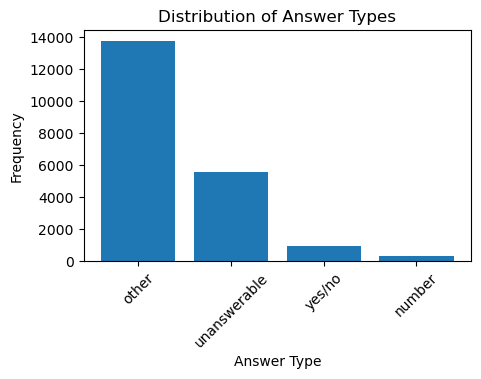

Train set size: 19496
Test set size: 1027


In [11]:
# Count the occurrences of each answer type
answer_type_counts = df['answer_type'].value_counts()

# Plot the histogram
plt.figure(figsize=(5, 3))
plt.bar(answer_type_counts.index, answer_type_counts.values)
plt.xlabel('Answer Type')
plt.ylabel('Frequency')
plt.title('Distribution of Answer Types')
plt.xticks(rotation=45)
plt.show()
# Verify the sizes of the train and test sets
print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

## 2) Building the Model (60 Points)

### b) You are allowed to use clip model image encoder and text encoder trained by OpenAi, the following is the paper link and in it you can find the github repo. 2103.00020.pdf(arxiv.org)

In [20]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

#### ViT-L/14@336px Model was used

In [12]:
model, preprocess = clip.load("ViT-L/14@336px")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 891M/891M [00:06<00:00, 147MiB/s]


Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


### Image tokenizing and encoding, Preparing pickle files


#### Training Dataset

In [18]:
image_paths = train_df['image_label'].tolist()  
images = []
#Image Reading
for path in image_paths:
    image = Image.open(DATA_DIR + 'train/train/' + path).convert("RGB")
    preprocessed_image = preprocess(image)  # Apply preprocessing
    images.append(preprocessed_image)
image_input = torch.tensor(np.stack(images)).cuda()
print("shape of training tensor is {0}".format(image_input.shape))

#Image Encoding
image_features = []
for i in range(0,image_input.shape[0],10):
    input_sample = image_input[i:i+10]
    with torch.no_grad():
            image_feature = model.encode_image(input_sample).float()
            image_features.extend(image_feature)
training_set = torch.vstack(tuple(image_features)).cuda()
print("shape of training encoded images is {0}".format(training_set.shape))
file = open('training_images', 'wb')
pickle.dump(training_set, file)
file.close()

shape of training tensor is torch.Size([1950, 3, 336, 336])
shape of training encoded images is torch.Size([1950, 768])


#### Testing Dataset

In [20]:
image_paths = test_df['image_label'].tolist()  
images = []

#Image Reading
for path in image_paths:
    image = Image.open(DATA_DIR + 'train/train/' + path).convert("RGB")
    preprocessed_image = preprocess(image)  # Apply preprocessing
    images.append(preprocessed_image)
image_input = torch.tensor(np.stack(images)).cuda()
print("shape of testing tensor is {0}".format(image_input.shape))

#Image Encoding
image_features = []
for i in range(0,image_input.shape[0],10):
    input_sample = image_input[i:i+10]
    with torch.no_grad():
            image_feature = model.encode_image(input_sample).float()
            image_features.extend(image_feature)
testing_set = torch.vstack(tuple(image_features)).cuda()
print("shape of tested encoded images is {0}".format(testing_set.shape))
file = open('testing_images', 'wb')
pickle.dump(testing_set, file)
file.close()

shape of testing tensor is torch.Size([103, 3, 336, 336])
shape of tested encoded images is torch.Size([103, 768])


#### Validation Dataset

In [19]:
image_paths = val_df['image'].tolist()  
images = []

#Image Reading
for path in image_paths:
    image = Image.open(DATA_DIR + 'val/val/' + path).convert("RGB")
    preprocessed_image = preprocess(image)  # Apply preprocessing
    images.append(preprocessed_image)
image_input = torch.tensor(np.stack(images)).cuda()
print("shape of validation tensor is {0}".format(image_input.shape))

#Image Encoding
image_features = []
for i in range(0,image_input.shape[0],10):
    input_sample = image_input[i:i+10]
    with torch.no_grad():
            image_feature = model.encode_image(input_sample).float()
            image_features.extend(image_feature)
validation_set = torch.vstack(tuple(image_features)).cuda()
print("shape of tested encoded images is {0}".format(validation_set.shape))
file = open('validation_images', 'wb')
pickle.dump(validation_set, file)
file.close()

shape of validation tensor is torch.Size([390, 3, 336, 336])
shape of tested encoded images is torch.Size([390, 768])


### Loading images from pickle file

In [15]:
file = open(PICKLE_DIR+'/training_images', 'rb')

# dump information to that file
training_set = pickle.load(file)
# close the file
file.close()

#________________________________________________________________
file = open(PICKLE_DIR+'/testing_images', 'rb')

# dump information to that file
testing_set = pickle.load(file)
# close the file
file.close()

#________________________________________________________________
file = open(PICKLE_DIR+'/validation_images', 'rb')

# dump information to that file
validation_set = pickle.load(file)
# close the file
file.close()

print_variable_shapes("training_set","testing_set","validation_set")

+----------------+--------------------------+
| Variable       | Shape                    |
+================+==========================+
| training_set   | torch.Size([19496, 768]) |
+----------------+--------------------------+
| testing_set    | torch.Size([1027, 768])  |
+----------------+--------------------------+
| validation_set | torch.Size([4319, 768])  |
+----------------+--------------------------+


### Text tokenizing and Encoding

#### Preparing pickle files

In [21]:
texts = train_df['question'].tolist()
text_tokens = clip.tokenize([ desc for desc in texts]).cuda()
print(len(text_tokens))

text_features = []
for i in range(0,len(text_tokens),10):
    input_sample = text_tokens[i:i+10]
    with torch.no_grad():
            text_feature = model.encode_text(input_sample).float()
            text_features.extend(text_feature)
text_features_training = torch.vstack(tuple(text_features)).cuda()
print(text_features_training.shape)
file = open('text_training', 'wb')
pickle.dump(text_features_training, file)
file.close()

#________________________________________________________________
texts = test_df['question'].tolist()
text_tokens = clip.tokenize([ desc for desc in texts]).cuda()
print(len(text_tokens))

text_features = []
for i in range(0,len(text_tokens),10):
    input_sample = text_tokens[i:i+10]
    with torch.no_grad():
            text_feature = model.encode_text(input_sample).float()
            text_features.extend(text_feature)
text_features_testing = torch.vstack(tuple(text_features)).cuda()
print(text_features_testing.shape)
file = open('text_testing', 'wb')
pickle.dump(text_features_testing, file)
file.close()

#__________________________________________________________________
texts = val_df['question'].tolist()
text_tokens = clip.tokenize([ desc for desc in texts]).cuda()
print(len(text_tokens))

text_features = []
for i in range(0,len(text_tokens),10):
    input_sample = text_tokens[i:i+10]
    with torch.no_grad():
            text_feature = model.encode_text(input_sample).float()
            text_features.extend(text_feature)
text_features_validation = torch.vstack(tuple(text_features)).cuda()
print(text_features_validation.shape)
file = open('text_validating', 'wb')
pickle.dump(text_features_validation, file)
file.close()


1950
torch.Size([1950, 768])
103
torch.Size([103, 768])
390
torch.Size([390, 768])


#### Loading from pickle files

In [16]:
file = open(PICKLE_DIR+'/training_text', 'rb')

# dump information to that file
text_features_training = pickle.load(file)
# close the file
file.close()

#__________________________________________________________________________________
file = open(PICKLE_DIR+'/testing_text', 'rb')

# dump information to that file
text_features_testing = pickle.load(file)
# close the file
file.close()

#_________________________________________________________________________________
file = open(PICKLE_DIR+'/validation_text', 'rb')

# dump information to that file
text_features_validation = pickle.load(file)
# close the file
file.close()

print_variable_shapes("text_features_training","text_features_testing","text_features_validation")

+--------------------------+--------------------------+
| Variable                 | Shape                    |
+==========================+==========================+
| text_features_training   | torch.Size([19496, 768]) |
+--------------------------+--------------------------+
| text_features_testing    | torch.Size([1027, 768])  |
+--------------------------+--------------------------+
| text_features_validation | torch.Size([4319, 768])  |
+--------------------------+--------------------------+


#### Concatenating 

In [17]:
training_set = torch.cat((training_set,text_features_training),1)
print("Training dataset_size:{0}".format(training_set.shape))
testing_set = torch.cat((testing_set,text_features_testing),1)
print("Testing dataset_size:{0}".format(testing_set.shape))
validation_set = torch.cat((validation_set,text_features_validation),1)
print("Validation dataset_size:{0}".format(validation_set.shape))

Training dataset_size:torch.Size([19496, 1536])
Testing dataset_size:torch.Size([1027, 1536])
Validation dataset_size:torch.Size([4319, 1536])


### Preparing Dataset

In [18]:
labels_map = {
    "other":0,
    "unanswerable":1,
    "yes/no":2,
    "number":3,
}

training_answers_types = torch.tensor([labels_map[index] for index in train_df['answer_type'].tolist()])
validation_answer_types = torch.tensor([labels_map[index] for index in val_df['answer_type'].tolist()])
testing_answer_types = torch.tensor([labels_map[index] for index in test_df['answer_type'].tolist()])

print_variable_shapes("training_answers_types","validation_answer_types","testing_answer_types")

+-------------------------+---------------------+
| Variable                | Shape               |
+=========================+=====================+
| training_answers_types  | torch.Size([19496]) |
+-------------------------+---------------------+
| validation_answer_types | torch.Size([4319])  |
+-------------------------+---------------------+
| testing_answer_types    | torch.Size([1027])  |
+-------------------------+---------------------+


In [19]:
onehot_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
# reshape the data to a 2D array and fit the encoder
labels_2d = [[label] for label in y_train]
onehot_encoder.fit(labels_2d)
# transform the labels into a one-hot encoded matrix
y_train_encoded = onehot_encoder.transform(labels_2d)
y_train_encoded = torch.tensor(y_train_encoded).cuda()

labels_2d = [[label] for label in y_val]
# transform the labels into a one-hot encoded matrix
y_valid_encoded = onehot_encoder.transform(labels_2d)
y_valid_encoded = torch.tensor(y_valid_encoded).cuda()


labels_2d = [[label] for label in y_test]
# transform the labels into a one-hot encoded matrix
y_test_encoded = onehot_encoder.transform(labels_2d)
y_test_encoded = torch.tensor(y_test_encoded).cuda()

print_variable_shapes("y_train_encoded","y_valid_encoded","y_test_encoded")

+-----------------+---------------------------+
| Variable        | Shape                     |
+=================+===========================+
| y_train_encoded | torch.Size([19496, 5497]) |
+-----------------+---------------------------+
| y_valid_encoded | torch.Size([4319, 5497])  |
+-----------------+---------------------------+
| y_test_encoded  | torch.Size([1027, 5497])  |
+-----------------+---------------------------+


### Answerability

In [20]:
y_train_answerablity = torch.tensor(train_df['answerable'].tolist())
y_test_answerability = torch.tensor(test_df['answerable'].tolist())
y_valid_answerability = torch.tensor(val_df['answerable'].tolist())

print_variable_shapes("y_train_answerablity","y_test_answerability","y_valid_answerability")

+-----------------------+---------------------+
| Variable              | Shape               |
+=======================+=====================+
| y_train_answerablity  | torch.Size([19496]) |
+-----------------------+---------------------+
| y_test_answerability  | torch.Size([1027])  |
+-----------------------+---------------------+
| y_valid_answerability | torch.Size([4319])  |
+-----------------------+---------------------+


### a)You will need to follow the implementation of this paper 2206.05281v1.pdf (arxiv.org)

#### Model

In [22]:
train_losses = []
train_accuracies = []
train_answerabilities = []

val_losses = []
val_accuracies = []
val_answerabilities = []

In [23]:
class LightningModel(pl.LightningModule):
    def __init__(self,vocab):
        super().__init__()
        
        # Learning rate and vocab length
        self.vocab = vocab
        self.lr = 0.0007585775750291836
        
        # Some initializations
        self.train_loss= []
        self.train_acc = []
        self.train_ans = []
        
        self.val_loss= []
        self.val_acc = []
        self.val_ans = []
        
        # Main Gate
        self.ln1 = torch.nn.LayerNorm(768*2)
        self.dp1 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(768 * 2, 512)
        
        # Answer Gate
        self.ln2 = torch.nn.LayerNorm(512)
        self.dp2 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(512, len(vocab))
        
        # Answer Type Gate
        self.fc_aux = torch.nn.Linear(512, 4)
        self.fc_gate = torch.nn.Linear(4, len(vocab))
        self.act_gate = torch.nn.Sigmoid()
        
        # Answerability Gate
        self.fc_answerable = torch.nn.Linear(1536,2)
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim =1)
        
    def forward(self,xc):
        # Main Gate
        x = self.ln1(xc)
        x = self.dp1(x)
        x = self.fc1(x)
        # Answer Type Gate
        aux = self.fc_aux(x)
        gate = self.fc_gate(aux)
        gate = self.act_gate(gate)
        # Answer Gate
        x = self.ln2(x)
        x = self.dp2(x)
        vqa = self.fc2(x)
        output = vqa * gate
        
        # Answerability Gate
        answerable = self.fc_answerable(xc)
        answerable = self.sigmoid(answerable)
        answerable = self.softmax(answerable)
        
        return output, aux, answerable
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    
    
    def training_step(self, batch, batch_idx):
        x, y_t, y_a, y_ans = batch
        y_hat, y_aux, y_answerable = self(x)
        predicated_answerability = torch.argmax(y_answerable, dim = 1)
        
        # Loss calculation
        loss = nn.CrossEntropyLoss()(y_hat, y_a)
        aux_loss = nn.CrossEntropyLoss()(y_aux, y_t)
        ans_loss = nn.CrossEntropyLoss()(y_answerable, y_ans)
        total_loss = loss + aux_loss + ans_loss
        self.train_loss.append(total_loss)
        
        # Training Accuracy
        predicted_answer = torch.argmax(y_hat, dim = 1)
        actual_answer = torch.argmax(y_a, dim = 1)
        training_accuracy = 0.0
        for i in range(y_a.shape[0]):
            if actual_answer[i] == predicted_answer[i]:
                training_accuracy +=1
        training_accuracy /= y_a.shape[0]
        self.train_acc.append(training_accuracy)
        
        # Answerability
        actual_answerability = y_ans
        answerability = 0.0
        for i in range(y_ans.shape[0]):
            if predicated_answerability[i] == actual_answerability[i]:
                answerability += 1
        answerability  /= y_ans.shape[0]
        self.train_ans.append(answerability)
        
        # Logs
        self.log("train_loss", total_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", training_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_answerability", answerability, prog_bar=True, on_step=False, on_epoch=True)
        
        
        
        train_loss.append(total_loss)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y_t, y_a, y_ans  = batch
        y_hat, y_aux, y_answerable = self(x)
        predicated_answerability = torch.argmax(y_answerable, dim = 1)
        
        # Loss calculation
        loss = nn.CrossEntropyLoss()(y_hat, y_a)
        aux_loss = nn.CrossEntropyLoss()(y_aux, y_t)
        ans_loss = nn.CrossEntropyLoss()(y_answerable, y_ans)
        total_loss = loss + aux_loss + ans_loss
        self.val_loss.append(total_loss)
        
        # Validation Accuracy
        predicted_answer = torch.argmax(y_hat, dim = 1)
        actual_answer = torch.argmax(y_a, dim = 1)
        validation_accuracy = 0.0
        for i in range(y_a.shape[0]):
            if actual_answer[i] == predicted_answer[i]:
                validation_accuracy +=1
        validation_accuracy /= y_a.shape[0]
        self.val_acc.append(validation_accuracy)
        
        # Answerability
        actual_answerability = y_ans
        answerability = 0.0
        for i in range(y_ans.shape[0]):
            if predicated_answerability[i] == actual_answerability[i]:
                answerability += 1
        answerability  /= y_ans.shape[0]
        self.val_ans.append(answerability)
        
        # Logs
        self.log('val_loss',  total_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc',  validation_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_answerability',answerability, prog_bar=True, on_step=False, on_epoch=True)
        
        val_loss.append(total_loss)
        return total_loss
    
    def predict_step(self, batch, batch_idx):
        x, y_t, y_a, y_ans = batch
        y_hat,y_aux, y_answerable = self(x)
        return y_hat,y_aux, y_answerable
    
    def save_model(self, path='model_bk.pt'):
        torch.save(self.state_dict(), path)
        
    def load_model(self, path='model_bk.pt'):
        self.load_state_dict(torch.load(path))
    
    def on_train_epoch_end(self):
        train_losses.append(sum(self.train_loss)/len(self.train_loss))
        self.train_loss=[]
        train_accuracies.append(sum(self.train_acc)/len(self.train_acc))
        self.train_acc=[]
        train_answerabilities.append(sum(self.train_ans)/len(self.train_ans))
        self.train_ans=[]
        self.save_model()
        
    def on_validation_epoch_end(self):
        val_losses.append(sum(self.val_loss)/len(self.val_loss))
        self.val_loss=[]
        val_accuracies.append(sum(self.val_acc)/len(self.val_acc))
        self.val_acc=[]
        val_answerabilities.append(sum(self.val_ans)/len(self.val_ans))
        self.val_ans=[]
   

#### Creating dataloaders

In [249]:
# for training
train_dataset = TensorDataset(training_set,training_answers_types,y_train_encoded,y_train_answerablity)
training_dataloader = DataLoader(train_dataset,batch_size=128)
# for validation
validation_dataset = TensorDataset(validation_set,validation_answer_types,y_valid_encoded,y_valid_answerability)
validation_dataloader = DataLoader(validation_dataset,batch_size=128)
# for testing
testing_dataset = TensorDataset(testing_set,testing_answer_types,y_test_encoded, y_test_answerability)
testing_dataloader = DataLoader(testing_dataset,batch_size=128)

#### Model Instantiation

In [250]:
plmodel = LightningModel(vocab)
trainer = pl.Trainer(max_epochs=150)
tuner = pl.tuner.tuning.Tuner(trainer)

#### Fine tuning and Optimizing learning rate

In [ ]:
lr_find_results = tuner.lr_find(
    plmodel,
    train_dataloaders=training_dataloader,
    min_lr=1e-7,
    max_lr=1e-3,
    early_stop_threshold=None
)

new_lr = lr_find_results.suggestion();
print("Suggested learning_rate " + str(new_lr))

#### Model Fitting

In [251]:
trainer.fit(plmodel,train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

#### Plotting accuracies and loss

In [257]:
def plot_evaluation(validation_values, training_values, window_size=10, evaluation_measure="Loss"):
    """Plots the validation and training values.

    Args:
        validation_values: A list of validation values.
        training_values: A list of training values.
        window_size: The window size for the smoothed curve.
        evaluation_measure: The name of the evaluation measure.
        plot_smoothed: Whether to plot the smoothed curves or not.

    Returns:
        None.
    """

    # Convert the tensors to NumPy arrays if necessary.
    if isinstance(validation_values[0], torch.Tensor):
        validation_values = [t.detach().cpu().numpy() for t in validation_values]
    if isinstance(training_values[0], torch.Tensor):
        training_values = [t.detach().cpu().numpy() for t in training_values]

    # Determine the lengths of the values.
    num_val_values = len(validation_values)
    num_train_values = len(training_values)

    # Generate the epoch numbers for the x-axis ticks.
    epochs = range(1, max(num_val_values, num_train_values) + 1)

    # Plot the raw values.
    plt.plot(epochs[:num_val_values], validation_values, label="Validation " + evaluation_measure)
    plt.plot(epochs[:num_train_values], training_values, label="Training " + evaluation_measure)

    # Add a title and labels to the axes.
    plt.title("Validation and Training " + evaluation_measure)
    plt.xlabel("Epoch")
    plt.ylabel(evaluation_measure)
    plt.legend()

    # Show the plot.
    plt.show()


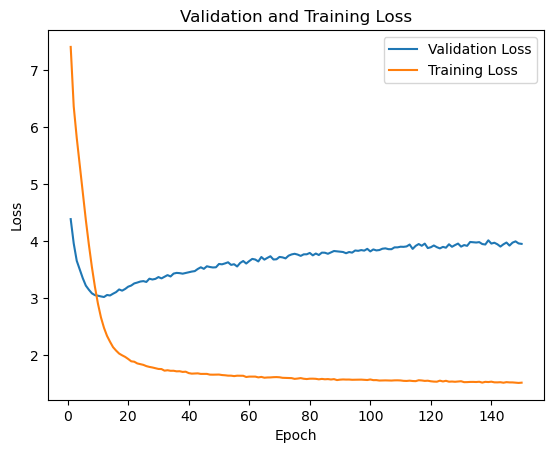

In [258]:
plot_evaluation(val_losses[1:], train_losses, window_size=10, evaluation_measure="Loss")

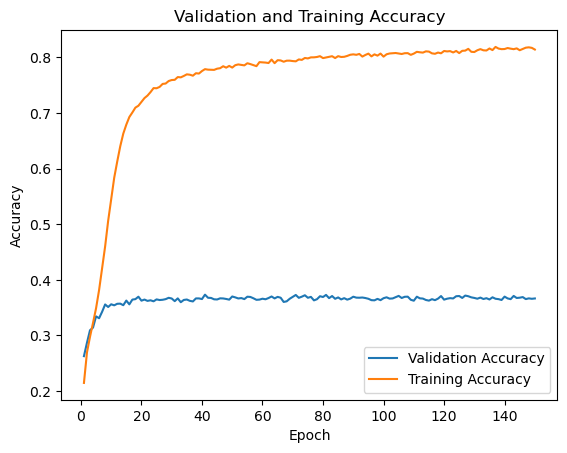

In [259]:
plot_evaluation(val_accuracies[1:], train_accuracies, evaluation_measure="Accuracy")

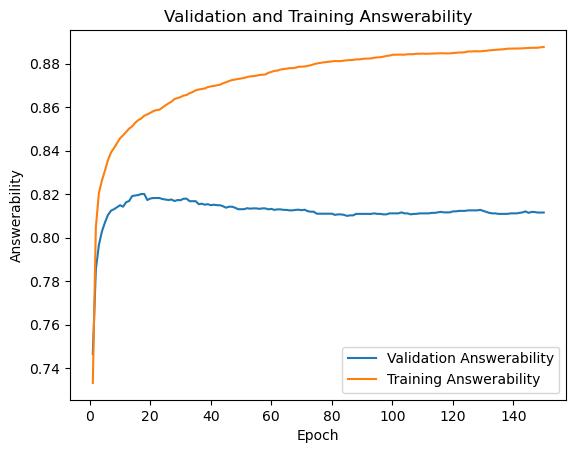

In [260]:
plot_evaluation(val_answerabilities[1:], train_answerabilities, evaluation_measure="Answerability")

In [266]:
# Create a list of lists for the table data
table_data = [
    ["Loss", train_losses[-1]],
    ["Accuracy", train_accuracies[-1]],
    ["Asnwerability", train_answerabilities[-1]]
]

# Print the table
table_headers = ["Training", "Value"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+---------------+----------+
| Training      |    Value |
+===============+==========+
| Loss          | 1.52161  |
+---------------+----------+
| Accuracy      | 0.813889 |
+---------------+----------+
| Asnwerability | 0.887623 |
+---------------+----------+


In [268]:
# Create a list of lists for the table data
table_data = [
    ["Loss", val_losses[-1]],
    ["Accuracy", val_accuracies[-1]],
    ["Asnwerability", val_answerabilities[-1]]
]

# Print the table
table_headers = ["Validation", "Value"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+---------------+----------+
| Validation    |    Value |
+===============+==========+
| Loss          | 3.95571  |
+---------------+----------+
| Accuracy      | 0.366484 |
+---------------+----------+
| Asnwerability | 0.811533 |
+---------------+----------+


#### Testing Accuracy

In [ ]:
predicated_output = trainer.predict(plmodel,dataloaders=testing_dataloader)

In [271]:
# Dealing with the batched output from the model
predicated_answers , predicated_answers_type, predicated_answerabilities = predicated_output[0]
# The first batch is already added to the output
# So we start from the second batch
for output in predicated_output[1:]:
    predicated_answer , predicated_answer_type, predicated_answerability = output
    predicated_answers = torch.cat((predicated_answers,predicated_answer),0)
    predicated_answers_type = torch.cat((predicated_answers_type,predicated_answer_type),0)
    predicated_answerabilities = torch.cat((predicated_answerabilities,predicated_answerability), 0)

print_variable_shapes("predicated_answers","predicated_answers_type","predicated_answerabilities")


# Calculating Testing Accuracy
predicated_answers = torch.argmax(predicated_answers, dim = 1)
true_answers = torch.argmax(y_test_encoded, dim = 1)
testing_accuracy = 0.0
for i in range(predicated_answers.shape[0]):
    if true_answers[i] == predicated_answers[i]:
        testing_accuracy +=1
testing_accuracy /= predicated_answers.shape[0]

# Calculating Testing Answerability
predicated_answerabilities = torch.argmax(predicated_answerabilities, dim = 1)
actual_answerabilities = y_test_answerability
answerability = 0.0
for i in range(predicated_answerabilities.shape[0]):
    if actual_answerabilities[i] == predicated_answerabilities[i]:
        answerability +=1
answerability /= predicated_answerabilities.shape[0]

# Create a list of lists for the table data
table_data = [
    ["Accuracy", testing_accuracy],
    ["Asnwerability", answerability]
]

# Print the table
table_headers = ["Testing", "Value"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+----------------------------+--------------------------+
| Variable                   | Shape                    |
+============================+==========================+
| predicated_answers         | torch.Size([1027, 5497]) |
+----------------------------+--------------------------+
| predicated_answers_type    | torch.Size([1027, 4])    |
+----------------------------+--------------------------+
| predicated_answerabilities | torch.Size([1027, 2])    |
+----------------------------+--------------------------+
+---------------+----------+
| Testing       |    Value |
+===============+==========+
| Accuracy      | 0.420643 |
+---------------+----------+
| Asnwerability | 0.843233 |
+---------------+----------+


In [71]:
def predict_answer(images, questions, preprocess, model, vocab):
    
    
    #Images Encoding
    sampled_images = model.encode_image(preprocess(images[0]).unsqueeze(0).cuda()).float()
    
    for image in images[1:]:
        preprocessed_image = preprocess(image)
        with torch.no_grad():
            sampled_images = torch.cat((sampled_images,model.encode_image(preprocessed_image.unsqueeze(0).cuda()).float()),0).cuda()
      
            
    print("Finished Processing Images ....")
    #Text Encoding
    sampled_tokens = clip.tokenize([ desc for desc in questions]).cuda()
    sampled_texts = torch.vstack(tuple(model.encode_text(sampled_tokens[0:10]).float())).cuda()
    text_features = []
    for i in range(10,len(sampled_tokens),10):
        input_sample = sampled_tokens[i:i+10]
        with torch.no_grad():
            sampled_texts = torch.cat((sampled_texts,torch.vstack(tuple(model.encode_text(input_sample).float()))),0).cuda()
        
    print("Finished Processing Questions ....")       
            
            
    sample_set = torch.cat((sampled_images,sampled_texts),1).cuda()
    sample_dataloader = DataLoader(TensorDataset(sample_set,sample_set,sample_set,sample_set), batch_size = 128)
    
    VQAmodel = LightningModel(vocab)
    trainer = pl.Trainer(max_epochs=1)
    VQAmodel.load_model(MODEL_DIR+'model_bk.pt')
    
    outputs = trainer.predict(VQAmodel,dataloaders=sample_dataloader)
    answers , answer_types, answerability = outputs[0]
    answers_index = torch.argmax(answers, dim=1)
    answers = vocab[answers_index]
    return answers

In [80]:
image_paths = sample_df['image'].tolist()[0:20] 
images = []

#Image Reading
for path in image_paths:
    image = Image.open(DATA_DIR + 'test/test/' + path).convert("RGB")
    images.append(image)
    
questions = sample_df['question'].tolist()[0:20]

answers = predict_answer(images,questions,preprocess, model, vocab)

Finished Processing Images ....
Finished Processing Questions ....


Predicting: 0it [00:00, ?it/s]

In [82]:
def keep_images(images, image_paths, questions, answers):
    """Keeps only the images and questions with the given indexes."""
    kept_images_paths = []
    kept_questions = []
    kept_answers = []
    kept_images = []
    for i, (image, path, question, answer) in enumerate(zip(images, image_paths, questions, answers)):
        if i in [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 16, 18, 19]:
            kept_images.append(image)
            kept_images_paths.append(path)
            kept_questions.append(question)
            kept_answers.append(answer)
    return kept_images, kept_images, kept_questions, kept_answers

images, image_paths, questions, answers = keep_images(images, image_paths, questions, answers)


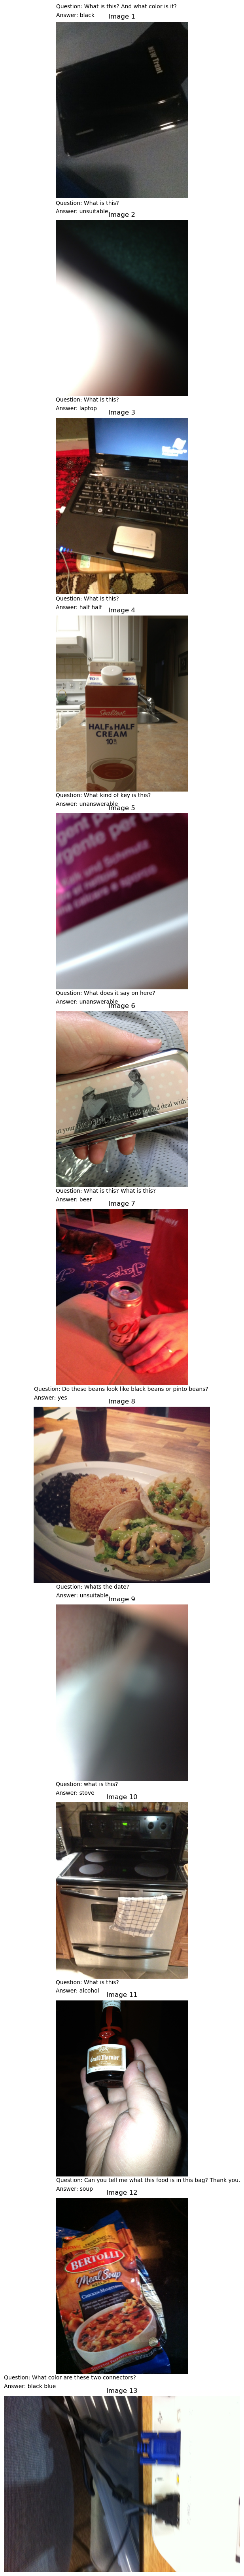

In [93]:
fig, axs = plt.subplots(len(images), 1, figsize=(8, 5 * len(images)))

for i, (image, question, answer) in enumerate(zip(images, questions, answers)):
    # Set the current subplot
    axs[i].axis('off')

    # Display the image
    axs[i].imshow(image)
    axs[i].set_title('Image {}'.format(i + 1), fontsize=12)

    # Adjust the spacing between the image and text
    axs[i].text(0, -image.size[1] * 0.1 + 10, 'Question: {}'.format(question), fontsize=10, wrap=True)
    axs[i].text(0, -image.size[1] * 0.05 + 10, 'Answer: {}'.format(answer), fontsize=10, wrap=True)

# Adjust the spacing between subplots and make them smaller
plt.subplots_adjust(hspace=1.5)
plt.tight_layout()

# Show the plot
plt.show()